In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from sklearn import datasets

In [3]:
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df = pd.DataFrame(normalize(df), columns=iris.feature_names)
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.803773          0.551609           0.220644          0.031521
1           0.828133          0.507020           0.236609          0.033801
2           0.805333          0.548312           0.222752          0.034269
3           0.800030          0.539151           0.260879          0.034784
4           0.790965          0.569495           0.221470          0.031639


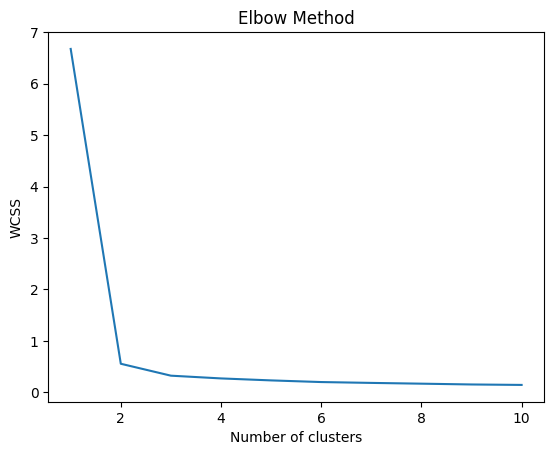

In [4]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


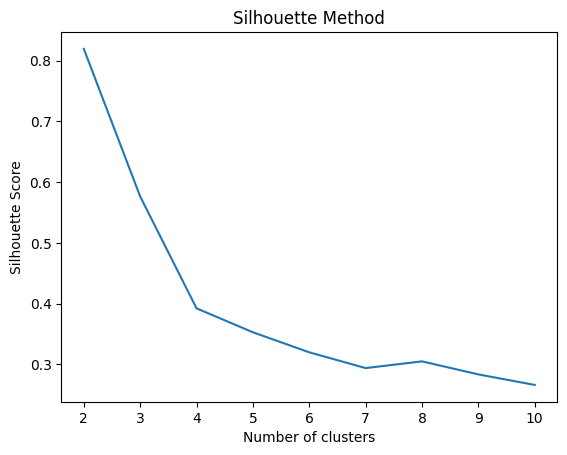

In [5]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(df)
    silhouette_scores.append(silhouette_score(df, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


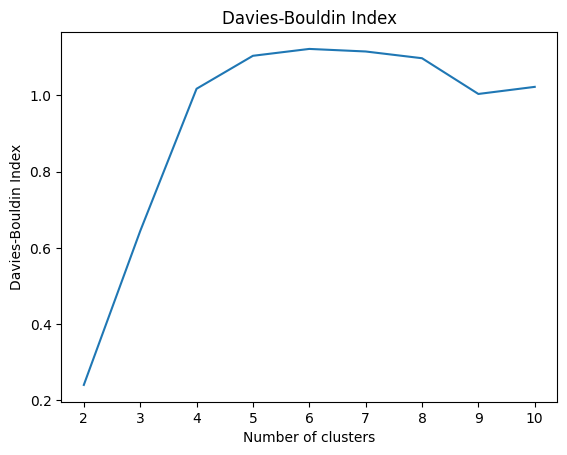

In [6]:
from sklearn.metrics import davies_bouldin_score

db_scores = []
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(df)
    db_scores.append(davies_bouldin_score(df, kmeans.labels_))

plt.plot(range(2, 11), db_scores)
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()


# Kmeans

In [7]:
# Choose the optimal number of clusters based on previous analyses, say k = 4
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df)
df['cluster'] = kmeans.labels_

""" for i in range(len(df)):
    if df['cluster'][i] == 0:
        df.loc[i, 'cluster'] = 1
    elif df['cluster'][i] == 1:
        df.loc[i, 'cluster'] = 0
errores = 0
for i in range(len(df)):
    if df['cluster'][i] != iris.target[i]:
        errores += 1
print(f'Total errors: {errores}') """

" for i in range(len(df)):\n    if df['cluster'][i] == 0:\n        df.loc[i, 'cluster'] = 1\n    elif df['cluster'][i] == 1:\n        df.loc[i, 'cluster'] = 0\nerrores = 0\nfor i in range(len(df)):\n    if df['cluster'][i] != iris.target[i]:\n        errores += 1\nprint(f'Total errors: {errores}') "

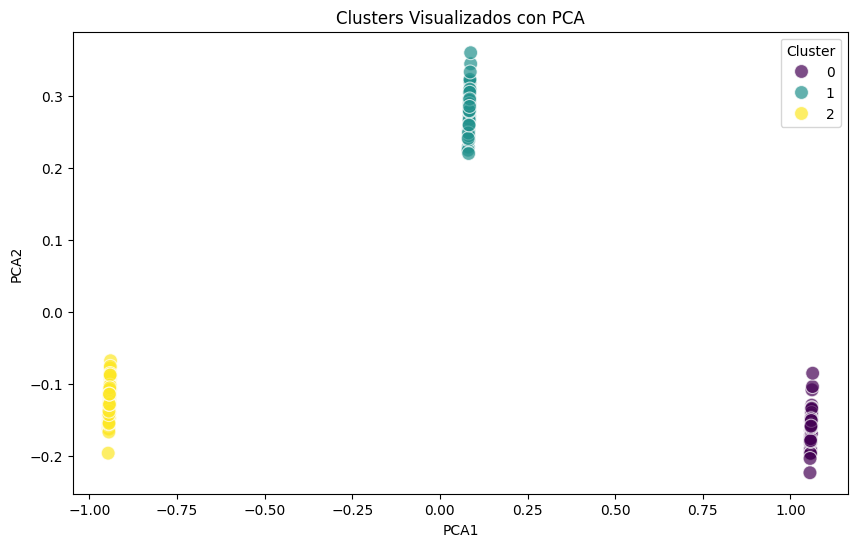

In [8]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df)

# Crear un DataFrame con las componentes principales y las etiquetas de los clusters
df_pca = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = kmeans.labels_

# Graficar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='viridis', data=df_pca, s=100, alpha=0.7)
plt.title('Clusters Visualizados con PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

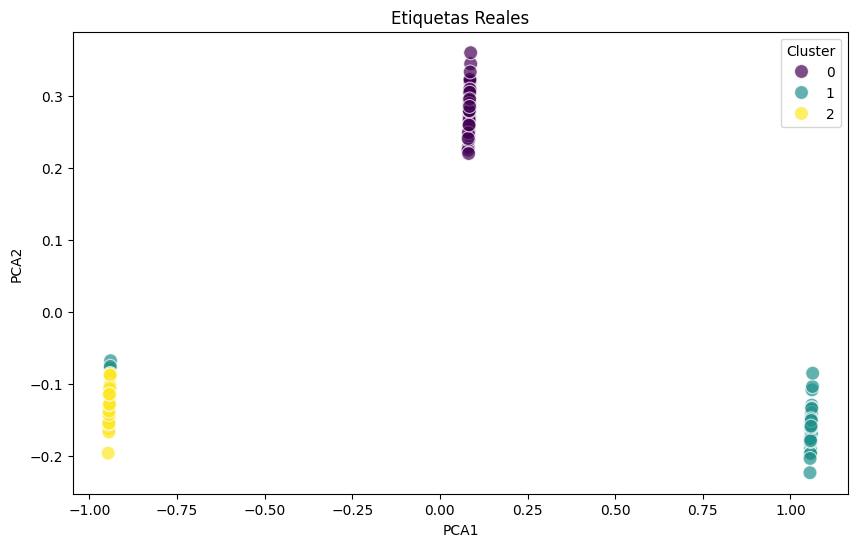

In [9]:
#comparar con las etiquetas reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=iris.target, palette='viridis', data=df_pca, s=100, alpha=0.7)
plt.title('Etiquetas Reales')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

Accuracy: 0.9
Accuracy: 0.9333333333333333


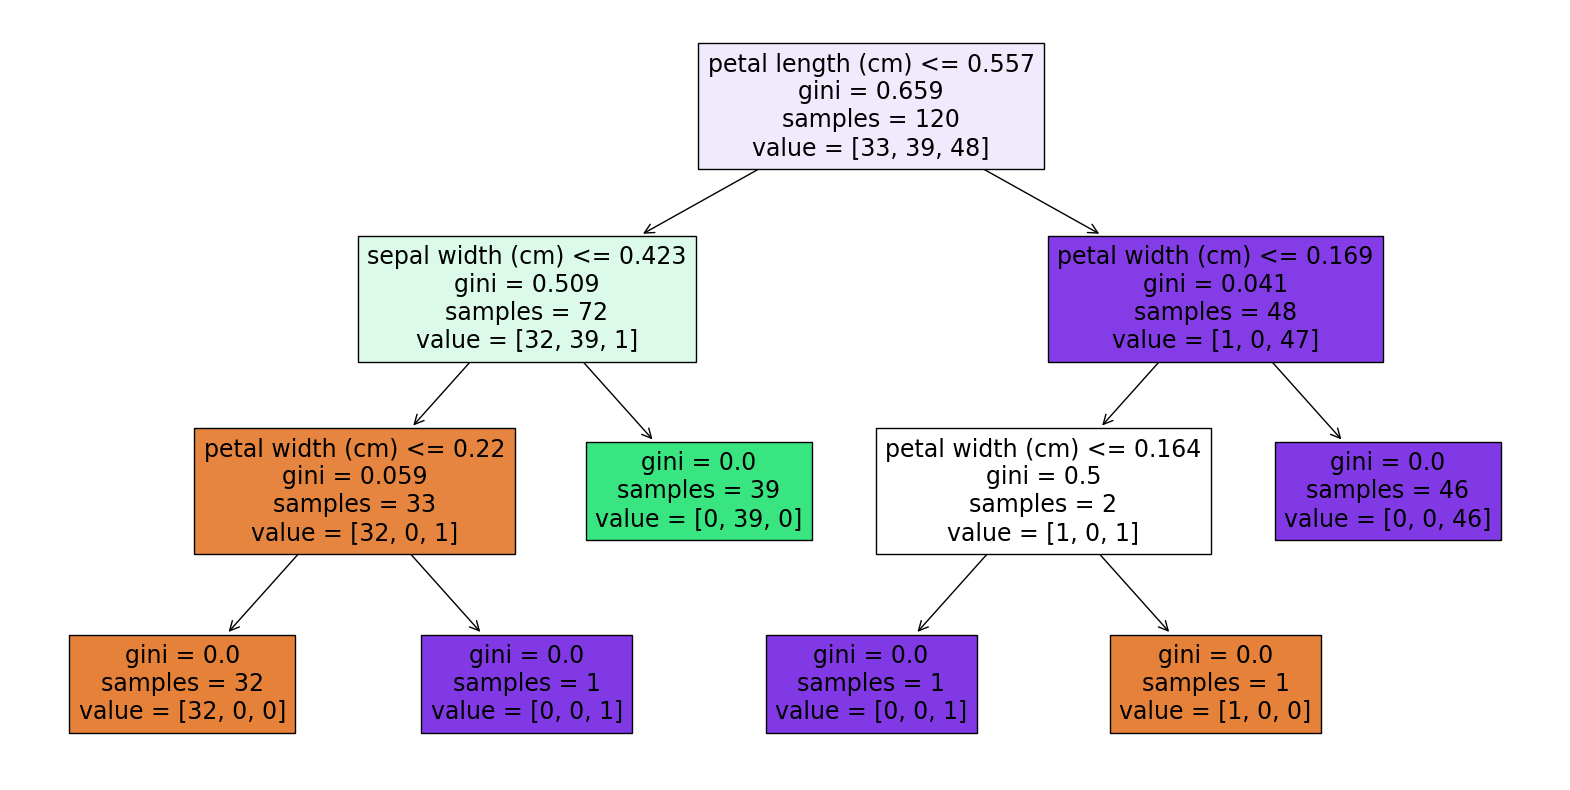

In [10]:
# evaluaemos con random forest si los clusters son buenos
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree

X = df.drop('cluster', axis=1)
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

#desicion tree
dt = DecisionTreeClassifier(max_depth=5, random_state=0)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
plt.figure(figsize=(20, 10))
tree.plot_tree(dt, filled=True, feature_names=iris.feature_names)
plt.show()

In [15]:
from dsgd.DSClassifierMultiQ import DSClassifierMultiQ
X_train_ds = X_train.to_numpy()
y_train_ds = y_train.to_numpy()
X_test_ds = X_test.to_numpy()
y_test_ds = y_test.to_numpy()


DSC = DSClassifierMultiQ(3, min_iter=20, max_iter=200, debug_mode=True, lr=0.005, 
                                lossfn="MSE", num_workers=1, min_dloss=1e-7, precompute_rules=True, force_precompute=True)

losses, epoch, dt = DSC.fit(X_train_ds, y_train_ds, add_single_rules=True,
                            single_rules_breaks=3, add_mult_rules=False,
                                column_names=iris.feature_names, print_every_epochs=1, print_final_model=False)
y_pred_ds = DSC.predict(X_test_ds)


Optimization started
Processing epoch	200	0.0119	
Training time: 350.20s, epochs: 200

Least training loss reached: 0.012


In [16]:
accuracy = accuracy_score(y_test_ds, y_pred_ds)
print('Accuracy:', accuracy)

Accuracy: 0.9333333333333333


In [19]:
DSC.print_most_important_rules(threshold=0.61)



Most important rules for class 0

	[0.757] R6: 0.402 < sepal width (cm) < 0.472
			0: 0.582	1: 0.403	2: 0.000	Unc: 0.016

	[0.667] R2: 0.751 < sepal length (cm) < 0.781
			0: 0.548	1: 0.264	2: 0.000	Unc: 0.188

	[0.660] R1: 0.721 < sepal length (cm) < 0.751
			0: 0.472	1: 0.000	2: 0.450	Unc: 0.077

	[0.648] R5: 0.332 < sepal width (cm) < 0.402
			0: 0.500	1: 0.000	2: 0.340	Unc: 0.160

Most important rules for class 1

	[0.630] R6: 0.402 < sepal width (cm) < 0.472
			0: 0.582	1: 0.403	2: 0.000	Unc: 0.016

Most important rules for class 2

	[0.645] R1: 0.721 < sepal length (cm) < 0.751
			0: 0.472	1: 0.000	2: 0.450	Unc: 0.077

	[0.643] R11: petal length (cm) > 0.565
			0: 0.000	1: 0.000	2: 0.643	Unc: 0.357


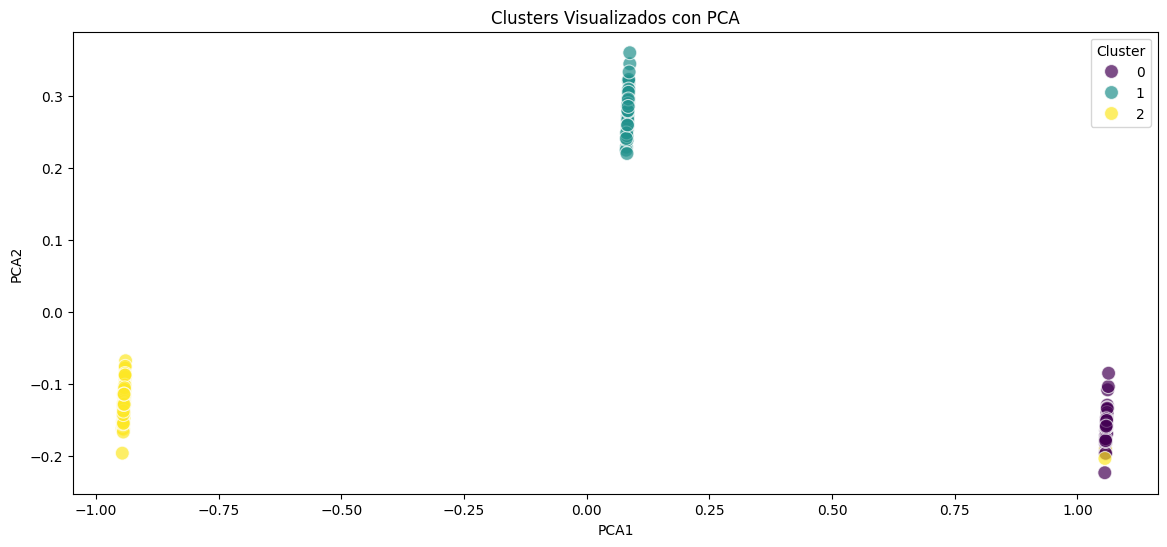

In [14]:
#imprimir el PCA pero con las etiquetas que predice el modelo
y_pred_dsFull = DSC.predict(X.to_numpy())
df_pca['clusterDSC'] = y_pred_dsFull

plt.figure(figsize=(14, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='clusterDSC', palette='viridis', data=df_pca, s=100, alpha=0.7)
# remarcar los puntos que no coinciden con las etiquetas reales

""" errores = 0
for i in range(len(df_pca)):
    if df_pca['clusterDSC'][i] == df['cluster'][i] and df['cluster'][i] != iris.target[i]:
        plt.scatter(df_pca['PCA1'][i], df_pca['PCA2'][i], c='red', s=100, alpha=0.7,)
        errores += 1
    elif df_pca['clusterDSC'][i] != df['cluster'][i] and df['cluster'][i] == iris.target[i]:
        plt.scatter(df_pca['PCA1'][i], df_pca['PCA2'][i], c='blue', s=100, alpha=0.7,)
        errores += 1

print('Errores:', errores) """
plt.title('Clusters Visualizados con PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()
